In [57]:
import h5py

# 打开HDF5文件
file = h5py.File('LDC2_spritz_mbhb1_training_v1.h5', 'r')

#查看文件中的数据
groups = list(file.keys())
print(groups)

for group_name in file.keys():
        print(f"Group: {group_name}")
        for dataset_name in file[group_name].keys():
            print(f"  Dataset: {dataset_name}")

#读取数据
all_data = {}

for group_name in file:
        group = file[group_name]
        all_data[group_name] = {}
        for dataset_name in group:
            try:
                data = group[dataset_name][()]
                all_data[group_name][dataset_name] = data
            except Exception as e:
                #去掉报错
                all_data[group_name][dataset_name] = str(e)
file.close()

['clean', 'header', 'instru', 'noisefree', 'obs', 'sky']
Group: clean
  Dataset: tdi
Group: header
  Dataset: date
Group: instru
  Dataset: config
Group: noisefree
  Dataset: tdi
Group: obs
  Dataset: config
  Dataset: tdi
Group: sky
  Dataset: cat
  Dataset: config
  Dataset: tdi


In [58]:
print(all_data['clean'])

{'tdi': array([[( 8899200.,  1.48846530e-16,  6.75330625e-17, -3.88519776e-16)],
       [( 8899205., -4.42617614e-16, -1.11055377e-16,  5.28572349e-16)],
       [( 8899210., -7.98086900e-16,  7.99285186e-16, -1.47198925e-15)],
       ...,
       [(11577585., -9.25155200e-21, -7.01214434e-21,  7.23238271e-21)],
       [(11577590.,  5.74426785e-21, -1.04391992e-21, -4.90782302e-21)],
       [(11577595., -4.26376105e-21,  8.22171527e-21,  2.00825311e-20)]],
      dtype=[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')])}


In [59]:
import WDMWaveletTransforms.wavelet_transforms as wavelettransforms

In [60]:
# t, X, Y, Z = all_data['clean']['tdi']['t'], all_data['clean']['tdi']['X'], all_data['clean']['tdi']['Y'], all_data['clean']['tdi']['Z']

In [61]:
import numpy as np
# clean = np.array(all_data['clean']['tdi']['X'] ).flatten()
# obs =  np.array(all_data['obs']['tdi']['X'] ).flatten()
# noisefree= np.array(all_data['noisefree']['tdi']['X'] ).flatten()
# sky = np.array(all_data['sky']['tdi']['X'] ).flatten()
# data = obs - clean
data = np.array(all_data['noisefree']['tdi']['X'] ).flatten()  # 确保数据类型为 float64
# data = np.array(all_data['clean']['tdi']['X'])  # 确保数据类型为 float64
# 目标长度
Nf = 512 
Nt = 256
desired_length = Nf * Nt

# 计算取样间隔
interval = len(data) // desired_length

# 使用切片提取数据
sampled_data = data[::interval]
# sampled_data = data[:desired_length]

# 确保取样数据长度正确
if len(sampled_data) > desired_length:
    sampled_data = sampled_data[:desired_length]
elif len(sampled_data) < desired_length:
    extra_samples = desired_length - len(sampled_data)
    sampled_data = np.append(sampled_data, data[:extra_samples])

print("Sampled Data Length:", len(sampled_data))
#小波变换
wave = wavelettransforms.transform_wavelet_time(sampled_data, Nf, Nt, 4.0, mult=1)
# wave = wavelettransforms.transform_wavelet_freq_time(sampled_data, Nf, Nt,8.0)

Sampled Data Length: 131072


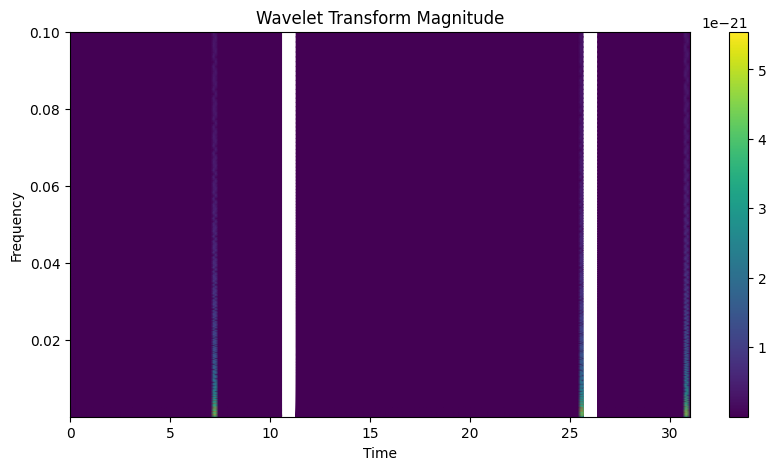

In [62]:
import matplotlib.pyplot as plt

time = np.linspace(0, 31, Nt)  
frequency = np.geomspace(0.0001, 0.1, Nf)  
# frequency = np.linspace(0.00001, 0.01)  


plt.figure(figsize=(10, 5))
plt.pcolormesh(time, frequency, np.abs(np.transpose(wave)), shading='gouraud')
# plt.yscale('log')
plt.colorbar(label='')  # 显示颜色条
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Wavelet Transform Spectrogram')
plt.show()

Text(0.5, 1.0, 'Wavelet Transform Spectrogram with Log Scale')

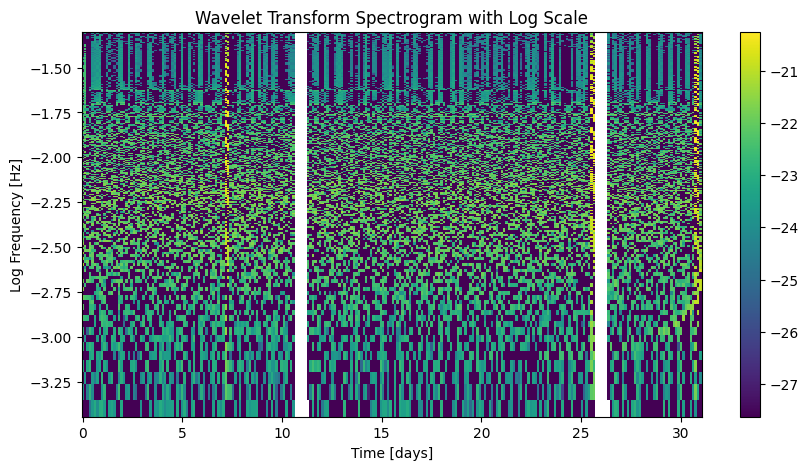

In [63]:
time = np.linspace(0, 31, Nt)  
# frequencies = np.geomspace(0.0001, 0.1, Nf) 
frequencies = np.linspace(0.0004, 0.05, Nf)  

#建立网格
time_grid, frequency_grid = np.meshgrid(time, frequencies)
wavelet = wave

min_threshold = wavelet[wavelet > 0].min()
wavelet_log = np.log10(np.maximum(wavelet, min_threshold)) #将小波变换的系数转变为对数
# simulated_wavelet_log = np.log10(simulated_wavelet)
# 画图
plt.figure(figsize=(10, 5))
# plt.pcolormesh(time_grid, np.log10(frequency_grid), simulated_wavelet_log, shading='nearest')
plt.pcolormesh(time_grid, np.log10(frequency_grid), np.transpose(wavelet_log), shading='auto')
# plt.pcolormesh(time_grid, frequency_grid, np.transpose(simulated_wavelet_log), shading='auto')
plt.colorbar(label='')
plt.xlabel('Time [days]')
plt.ylabel('Log Frequency [Hz]')
plt.title('Wavelet Transform Spectrogram with Log Scale')
# plt.yscale('log')  # 设置y轴为对数标度